# REM Memory Example

## Task Explanation

Model is used to explain performance in Episodic Memory Task. 

The task goes as follows: 
- Subject is given a list of study items (e.g.) words and has to learn them. 
- After studying a filler task is performed (e.g. completing a puzzle.) 
- In the test phase, the subject is presented with items, that were either on the study set or are entirely new. 
- The subject has to respond with "old" if the item has been encountered the study phase, or "new" if the item has not been encountered in the study phase. 

Learned words are called "targets" and words which where not learned are called "distractors". 

For simplicity we focus on two cases:
- $hit:$ target is presented and subject correctly responds with 'old'
- $false-alarm:$ distractor is presented and subject incorrectly responds with 'old'

## Model Explanation

REM is a global memory which means that the recognition response of a single memory probe is based on a calculation of familiarity between the probe item and all other items of the study list. Each Item is composed of a list of feature or feature vector with w dimensions. This vector is called trace. The psychological interpretation of this trace is ... 

### Feature Generation 

Mathematically speaking each of the features follow a geometric distribution:

$P(K = k) = (1-g)^{k-1} *g$ with $k \; \epsilon \; [1,2,... \infty] $ and $g \; \epsilon \; (0,1)$ 

where g is the so called 'environmental base rate' which is high for high-frequency words and lower for low-frequency words. Because for large values of g as in high-frequency, the variance for different values for a feature K will be lower, thus they will have more common features, which makes them less distinct.

Example:

- q = 0.35 -> [ 1  2  5  8  6  2  2  1  2 10  4  1  1  1  1  5  3  8  2  1] indicating that a high-frequency word is less distinct in their features
- q = 0.1 -> [ 2 37  9 29 11 11 19 13  4 15  9  6  7 30 13  2 13  5  8  2] indicating that a low-frequency word is more distinct in their features


### 1) Study of Words (storage)

During study the features of a given word are copied to a memory trace. This copying process is error-prone and incomplete. Initially the representation of a feature vector for a particular item only contains zeros. Then the copying process fills the vector with values according to the following probabilities 

- $u:$ A feature is copied with this probabilty and not copied with the probability $1-u$ meaning the entry will remain zero
- $c:$ A feature when copied, can still be copied incorrectly with this probability. In the opposite case $1-c$ a feature will be copied randomly by drawing again from the geometric distribution using base rate $g$. 


The copying process consists of two steps:
1. A feature is copied into trace with probability u and will remain empty with probability 1-u
2. A feature is copied correctly with probability c and incorrectly 1-c by resampling

This is repeated for each feature of all studies items. This can be represented in a wxn matrix called the episodic matrix.


### 2) Recall of Words (retrieval)

During retrieval we are presented with a test-item (probe), that is then compared to each trace in the episodic matrix. We need to calculate the following to quantities:

- $n_{jq}$ which tells us the number of non-zero mismatching features in the trace j 
- $n_{ijm}$ which tells us the number of non-zero matching type features in the j-th trace with the value of i

Then similarity $ \lambda _{j}$ is calculated in the following expression:

$ \lambda _{j} = (1-c)^{n_{jq}} \prod_{i = 1}^{\infty} \left[  \frac{c+(1-c)g(1-g)^{i-1}}{g(1-g)^{i-1}} \right]^{n_{ijm}} $ 


The overall familarity with a given probe item can then be written as its expectation over the similarities with each trace item 
$ \phi = \frac{1}{n} \sum_{j = 1}^{n} \lambda _{j} $

The familiarity $\phi$ then is actually the expectation of a likelihood ratio: 
the probability that the probe is a target divided by the probability that the probe is a distractor. The Bayesian Decision rules then states to accept such probes that $ \phi > 1$ meaning an "old"-response is given. In the opposite case a "new" response is given.

We now do this for every probe item and count the the number of 'old' responses, which we then use to assess wether those were hits or false alarms

# Model Inference

Our goal is now to infer the parameters g,u and c for a single simulated subject in a recognition memory experiment with two list-length (n either 10 or 20) conditions. The test lists consist of the entire previously list plus 10 or 20 distactor items for the short and long list conditions. 

The following 3 stages will be required:

1. Select values for g, u , c and generate a stimulus set using parameter g. 
2. Fill the Episodic Matrix during the study phase using the parameters g,u and c.
3. Finally complete the test-phase by using the same parameters g, u in the equation $ \lambda _{j} = (1-c)^{n_{jq}} \prod_{i = 1}^{\infty} \left[  \frac{c+(1-c)g(1-g)^{i-1}}{g(1-g)^{i-1}} \right]^{n_{ijm}} $ 

We set  $g,u,c \sim Beta(1,1)$

These parameters are used over each condition, the only quantity that changes is the is the size of the study list, which is specific to the conditiion


## Distance Function:

In each recognition memory experiment we observed the number of hits and false alarms across the different conditions.
For a condition j we calculate the following:

$ Y_{j,HIT} \sim Bin(n_{j, OLD} , p_{HIT} )$ and $Y_{j, FA} \sim Bin(n_{j, NEW} , p_{FA} )$. 

The likelihood of the joint event $(Y_{j, HIT}, Y_{j, FA} ) $ -> the product of the two probabilities


The distance function then is described as 

$\rho(X,Y) = \frac{1}{2C} \left[ \sum_{j = 1}^{C} \left| \; (x_{j,FA} - Y_{j,FA}) / N_{new} \; \right|
+ \sum_{j = 1}^{C} \left| \; (x_{j,HIT} - Y_{j,HIT}) / N_{old} \right| \right] $ with a maximum value of one

In [15]:
import numpy as np
import scipy.stats as ss
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import acm2017_pyabc.prior
from acm2017_pyabc.plots import plot_marginals, plot_pairs
from acm2017_pyabc.examples import rem_memory
%matplotlib notebook

In [3]:
def calculate_hit_fa_rate(results): 
    summarized = np.zeros((len(results), 4))
    for i in range(len(results)):
        result = results[i]
        
        #currently only supports test lists that are twice the size of study
        n_study = int(len(result) / 2)
        n_test = len(result)
    
        n_hits = np.sum(result[0:n_study]) 
        n_fa = np.sum(result[n_study:])
        
        summarized[i,:] = [n_hits,n_fa, n_study, (n_test - n_study)]
    
    return summarized

The distance function then is described as 

$\rho(X,Y) = \frac{1}{2C} \left[ \sum_{j = 1}^{C} \left| \; (x_{j,FA} - Y_{j,FA}) / N_{new} \; \right|
+ \sum_{j = 1}^{C} \left| \; (x_{j,HIT} - Y_{j,HIT}) / N_{old} \right| \right] $ with a maximum value of one

In [4]:
def distance_function(x, y):
    hit = 0
    fas = 0 
    conditions = int(len(x) / 4)
    for i in range(conditions):     
        hit += np.abs( (x[i*4+0]-y[i*4+0]) / y[i*4+2]) 
        fas += np.abs( (x[i*4+1]-y[i*4+1])  / y[i*4+3])    
    return 1/(2*conditions) * (fas+hit)

def distance_function2(x, y):
    hit = 0
    fas = 0 
    conditions = int(len(x))
    for i in range(conditions):     
        hit += np.abs( (x[i,0]-y[i,0]) / y[i,2]) 
        fas += np.abs( (x[i,1]-y[i,1])  / y[i,3])    
    return 1/(2*conditions) * (fas+hit)

In [5]:
g = 0.6
u = 0.335
c = 0.7

simulator = lambda u, g, c: rem_memory.simulator(u, g, c, w=9, conditions=[10,20])


y0 = simulator(u,g,c)

#we set g = 0.6, u = 0.335, and c = 0.7.

g_prior = acm2017_pyabc.Prior("beta", 1, 1, name="g")
u_prior = acm2017_pyabc.Prior("beta", 1, 1, name="u")
c_prior = acm2017_pyabc.Prior("beta", 1, 1, name="c")

#y = simulator(g_prior.sample(),u_prior.sample(), c_prior.sample()) 

#y0_summary = calculate_hit_fa_rate(y0)
#y_summary = calculate_hit_fa_rate(y)

#distance_function(y0_summary,y_summary)

In [ ]:
x = simulator(u,g,c)
y = simulator(u_prior.sample(),g_prior.sample(),c_prior.sample())

x_summary = calculate_hit_fa_rate(x)
y_summary = calculate_hit_fa_rate(y)

distance_function2(x_summary,y_summary)

In [10]:
rej = acm2017_pyabc.RejectionSampler(priors=[u_prior,g_prior,c_prior], simulator=simulator, 
                             summaries=[calculate_hit_fa_rate], distance = distance_function,
                             observation=y0)
smc = acm2017_pyabc.SMCSampler(priors=[u_prior,g_prior,c_prior], simulator=simulator, 
                             summaries=[calculate_hit_fa_rate], distance = distance_function,
                             observation=y0, verbosity = True)
mcmc = acm2017_pyabc.MCMCSampler(priors=[u_prior,g_prior,c_prior], simulator=simulator, 
                             summaries=[calculate_hit_fa_rate], distance = distance_function,                   
                         observation=y0, verbosity = True)
abcde = acm2017_pyabc.ABCDESampler(priors=[u_prior,g_prior,c_prior], simulator=simulator, 
                             summaries=[calculate_hit_fa_rate], distance = distance_function,                   
                         observation=y0, verbosity = True, exp_lambda = 5)
bolfi = acm2017_pyabc.BOLFI(priors=[u_prior,g_prior,c_prior], simulator=simulator, 
                             summaries=[calculate_hit_fa_rate], distance = distance_function,                   
                         observation=y0, verbosity = True, domain=[(0,1), (0,1), (0,1)])

In [7]:
rej.sample(nr_samples = 1000, threshold = 0.03)

Rejection sampler started with threshold: 0.03 and number of samples: 1000


KeyboardInterrupt: 

In [ ]:
smc.sample(nr_samples=1000, thresholds=[0.5, 0.2, 0.15, 0.1, 0.08, 0.06,0.03])

In [ ]:
mcmc.sample(nr_samples=1000, threshold = 0.03, step_size = [0.05,0.05,0.05])

In [18]:
abcde.sample(nr_samples=1000, nr_groups = 1, nr_iter = 100, burn_in = 50, alpha = 0.1, beta = 0.1, kappa = 0.9)

ABC-Differential-Evolution sampler started with number of samples: 1000
initializing pools
Samples:   1000 - Iterations:        100 - Acceptance rate: None - Time: 14713.16 s


<IPython.core.display.Javascript object>


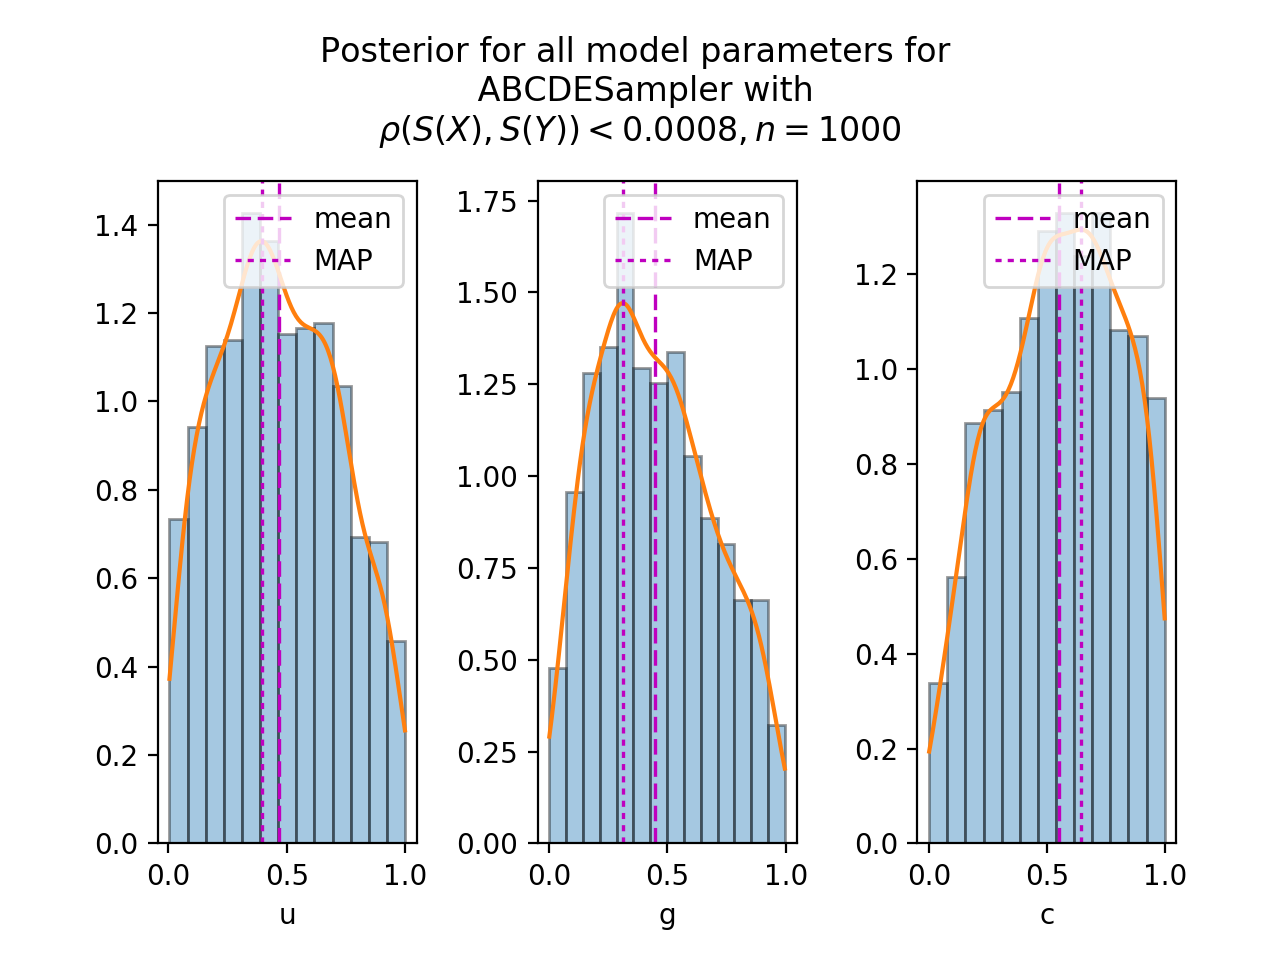

<IPython.core.display.Javascript object>


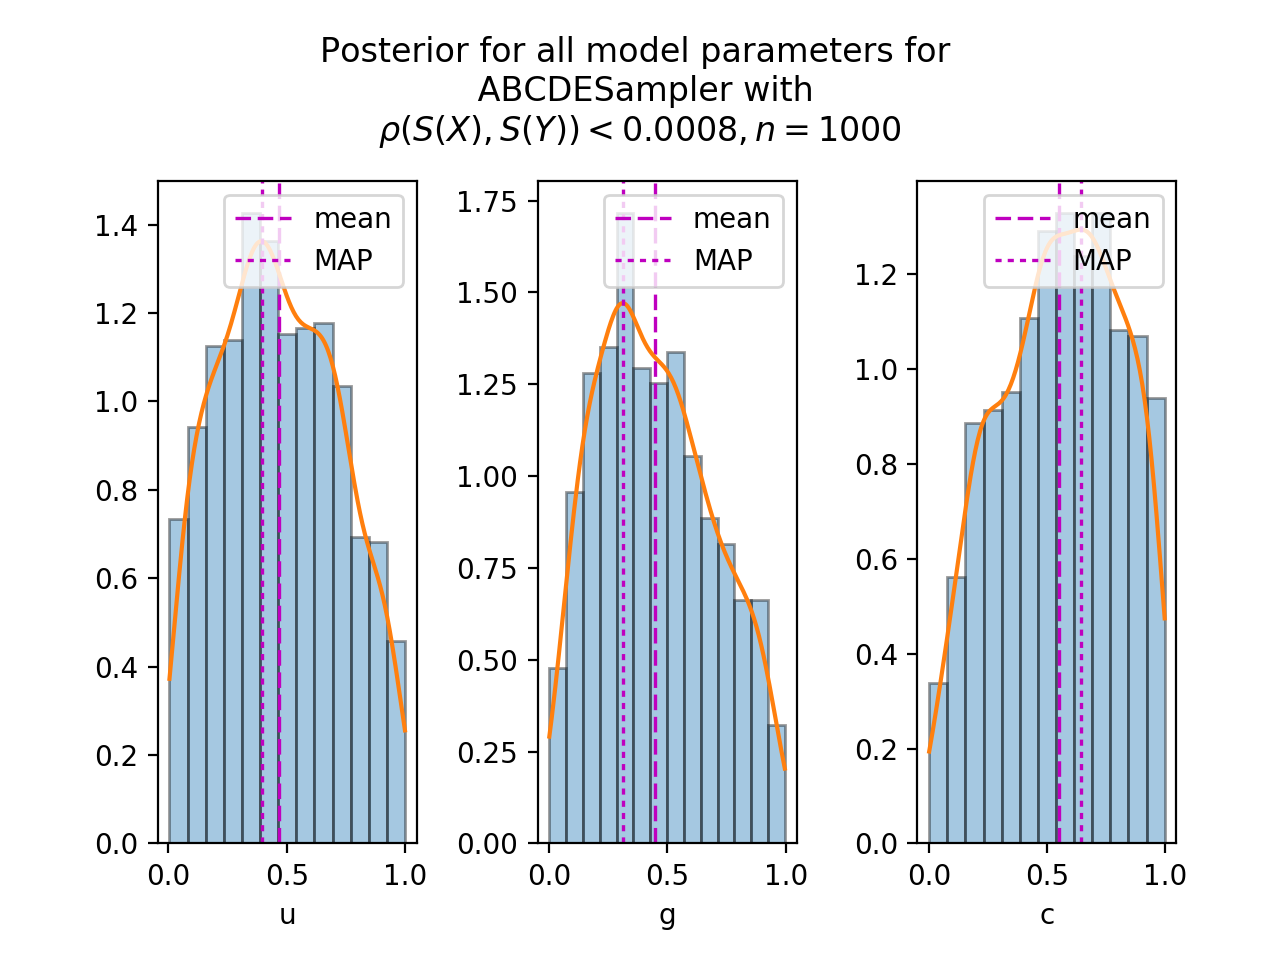

In [20]:
plot_marginals(abcde)

In [17]:
bolfi.sample(nr_samples=10000, threshold=0.01, n_chains=10)

BOLFI sampler started with threshold: 0.01 and number of samples: 10000
Starting Bayesian Optimization


ValueError: negative dimensions are not allowed

In [ ]:
plot_marginals(rej, kde=True, normed=True)
plot_marginals(mcmc, kde=True, normed=True)
plot_marginals(smc, kde=True, normed=True)
plot_marginals(abcde, kde=True, normed=True)
plot_marginals(bolfi, kde =True, normed=True)

In [ ]:
#Debugging of individual functions  
#Sanity Check comparing our math to (Shiffrin 1997 Figure 1)
c = 0.7
gh = 0.45
g = 0.4
u = 0.5

study_target1 = np.array([6,1,1,3])
study_target2 = np.array([3,2,1,1])
study_list = [study_target1, study_target2]

episodic_image1 = np.array([0,1,0,3])
episodic_image2 = np.array([2,2,1,0])
episodic_matrix = [episodic_image1,episodic_image2]

probe_dist = np.array([2,3,4,3])
probe_target = np.array([6,1,1,3])
probe_list = [probe_dist,probe_target]


n_test = len(probe_list)
results = np.zeros(n_test)

for i in range(n_test):
        total = 0 
        for j in range(len(episodic_matrix)):
            total += calculate_similarity(probe_list[i],episodic_matrix[j],u,g,c)
   
        phi = 1/(len(probe_list)) * total
    
        if phi > 1: 
            results[i] = 1 
        else:
            results[i] = 0     
        print("----")  
        print('phi:', phi)
        print('accept:' , results[i])
        print("----")